In [1]:
import os
import scipy.io as sio
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     concatenate, BatchNormalization, Dropout)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 1. Caricamento delle posizioni dei microfoni

def load_sensor_locations(excel_path):
    """
    Carica le posizioni dei microfoni da un file Excel, saltando la prima riga.
    Devono esserci almeno le colonne 'Mic #', 'x', 'y', 'dx', 'dy'.
    Ritorna un DataFrame con le colonne ['Mic #', 'x', 'y'].
    """
    df = pd.read_excel(excel_path, skiprows=1)
    expected_columns = ['Mic #', 'x', 'y', 'dx', 'dy']
    if len(df.columns) >= len(expected_columns):
        df = df.iloc[:, :len(expected_columns)]
        df.columns = expected_columns
        return df[['Mic #', 'x', 'y']]
    else:
        print("Errore: il file non contiene le colonne attese.")
        return None

In [2]:
# 2. Caricamento dati .mat (limitando canali e campioni, normalizzazione)

def load_mat_data(folder_path, key="singleData", max_channels=65, duration_sec=10, original_freq=204800):
    """
    Carica i file ChannelX.mat, limitando a 'max_channels' e 'duration_sec' secondi.
    Normalizza i dati in [-1,1] e converte in float16 per risparmiare memoria.
    Ritorna un array di shape (n_canali, n_campioni).
    """
    data_list = []
    min_length = float('inf')
    max_samples = int(duration_sec * original_freq)

    for root, _, files in os.walk(folder_path):
        channel_files = sorted([f for f in files if f.startswith("Channel") and f.endswith(".mat")])
        channel_files = channel_files[:max_channels]

        for file in channel_files:
            file_path = os.path.join(root, file)
            mat_data = sio.loadmat(file_path, squeeze_me=True)
            if key in mat_data and isinstance(mat_data[key], np.ndarray):
                data = mat_data[key].astype(np.float32)
                print(f"Caricato {file_path}, shape: {data.shape}")

                # Se 1D, converti in 2D
                if data.ndim == 1:
                    data = np.expand_dims(data, axis=0)

                # Limita ai primi max_samples campioni (ad es. 5 secondi)
                if data.shape[1] > max_samples:
                    data = data[:, :max_samples]

                # Normalizzazione in [-1,1]
                max_val = np.max(np.abs(data))
                if max_val > 0:
                    data /= max_val

                data_list.append(data)
                min_length = min(min_length, data.shape[1])
            else:
                print(f"{file_path} non contiene '{key}', ignorato.")

    if not data_list:
        print("Nessun file valido trovato.")
        return None

    # Taglia tutti gli array alla lunghezza minima comune
    data_list = [d[:, :min_length] for d in data_list]
    final_array = np.vstack(data_list).astype(np.float16)
    print(f"Dati caricati con shape finale: {final_array.shape} (float16)")
    return final_array

In [3]:
# 3. Downsampling con filtro passa-basso

def downsample_data(data, original_freq=204800, target_freq=50000):
    """
    Applica un filtro passa-basso e riduce la freq. a target_freq.
    """
    nyquist = target_freq / 2
    cutoff = nyquist * 0.9
    order = 4
    b, a = butter(order, cutoff / (original_freq / 2), btype='low', analog=False)
    downsampled_data = []

    for i in range(data.shape[0]):
        print(f"Filtraggio e downsampling per canale {i+1}/{data.shape[0]}...")
        signal = np.nan_to_num(data[i], nan=0.0, posinf=0.0, neginf=0.0)
        filtered_signal = filtfilt(b, a, signal)
        num_samples_new = int(len(filtered_signal) * (target_freq / original_freq))
        downsampled_signal = resample(filtered_signal, num_samples_new).astype(np.float16)
        downsampled_data.append(downsampled_signal)

    return np.array(downsampled_data, dtype=np.float16)

In [4]:
# 4. Creazione dataset multi-time-step (interpolazione su griglia 2D)

def create_multistep_dataset(sensor_data, positions, grid_size=(128,128), step=1000):
    """
    Per ogni time-step in range(0, total_samples, step),
    interpola i valori su una griglia 2D (64x64).
    Ritorna un array di immagini di forma (n_time_steps, grid_size[1], grid_size[0], 1).
    """
    x = positions['x'].values
    y = positions['y'].values
    n_sensors = len(x)

    # Usa solo i canali corrispondenti al numero di sensori
    sensor_data = sensor_data[:n_sensors, :]
    total_samples = sensor_data.shape[1]

    print(f"Creazione dataset multi-time-step: total_samples={total_samples}, step={step}")
    grid_x = np.linspace(x.min(), x.max(), grid_size[0])
    grid_y = np.linspace(y.min(), y.max(), grid_size[1])
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)

    images = []
    for t in range(0, total_samples, step):
        # sensor_data[:, t] => shape (n_sensors,)
        values = sensor_data[:, t]
        grid_z = griddata((x, y), values, (grid_x, grid_y), method='cubic')
        if grid_z is None:
            print(f"Interpolazione fallita al time-step {t}, mettiamo zeros.")
            grid_z = np.zeros(grid_x.shape, dtype=np.float32)
        else:
            grid_z = np.nan_to_num(grid_z, nan=0.0)
        grid_z = grid_z.astype(np.float32)[..., np.newaxis]  # (h,w,1)
        images.append(grid_z)

    dataset_images = np.array(images, dtype=np.float32)  # (n_time_steps, h, w, 1)
    print(f"Dataset interpolato shape: {dataset_images.shape}")
    return dataset_images

In [5]:
# 5. Semplice Data Augmentation (flip orizzontale)

def simple_augment(image, label):
    # Flip orizzontale casuale
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)
    return image, label

In [6]:

# 6. U-Net profonda con BN e Dropout

def unet_2d_deep(input_shape=(64,64,1), base_filters=32, dropout_rate=0.1):
    inputs = Input(shape=input_shape)

    # Down 1
    c1 = Conv2D(base_filters, (3,3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(base_filters, (3,3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout_rate)(p1)

    # Down 2
    c2 = Conv2D(base_filters*2, (3,3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(base_filters*2, (3,3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(dropout_rate)(p2)

    # Down 3
    c3 = Conv2D(base_filters*4, (3,3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(base_filters*4, (3,3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(dropout_rate)(p3)

    # Bottleneck
    c4 = Conv2D(base_filters*8, (3,3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(base_filters*8, (3,3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Up 1
    u5 = UpSampling2D((2,2))(c4)
    u5 = concatenate([u5, c3])
    u5 = Dropout(dropout_rate)(u5)
    c5 = Conv2D(base_filters*4, (3,3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(base_filters*4, (3,3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Up 2
    u6 = UpSampling2D((2,2))(c5)
    u6 = concatenate([u6, c2])
    u6 = Dropout(dropout_rate)(u6)
    c6 = Conv2D(base_filters*2, (3,3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(base_filters*2, (3,3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    # Up 3
    u7 = UpSampling2D((2,2))(c6)
    u7 = concatenate([u7, c1])
    u7 = Dropout(dropout_rate)(u7)
    c7 = Conv2D(base_filters, (3,3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(base_filters, (3,3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    outputs = Conv2D(1, (1,1), activation='linear')(c7)
    model = Model(inputs, outputs)
    return model


In [7]:
# 7. Loss combinata MSE + alpha*(1 - SSIM)

def combined_loss(y_true, y_pred, alpha=0.5):
    # MSE
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    # SSIM in [0,1], se i dati sono in [-1,1] si può fare un rescale
    ssim_val = tf.image.ssim(y_true, y_pred, max_val=2.0)  # se i dati sono in [-1,1], max_val=2
    ssim_loss = 1.0 - tf.reduce_mean(ssim_val)
    return mse + alpha * ssim_loss

In [8]:
# 8. Training con data augmentation e callback avanzati

def train_model(dataset_images, epochs=100, batch_size=16, validation_split=0.2, alpha=0.5):
    """
    dataset_images: (n_time_steps, h, w, 1) in [-1,1]
    alpha: peso per la componente (1 - SSIM)
    """
    # Target = input (autoencoder)
    X = dataset_images
    Y = dataset_images

    # Divisione in training e validation
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=validation_split, random_state=42)

    # tf.data.Dataset
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    # Data augmentation (flip orizzontale)
    train_ds = train_ds.map(simple_augment, num_parallel_calls=tf.data.AUTOTUNE)

    train_ds = train_ds.batch(batch_size).shuffle(100).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    model = unet_2d_deep(input_shape=X.shape[1:], base_filters=64, dropout_rate=0.1)

    def loss_fn(y_true, y_pred):
        return combined_loss(y_true, y_pred, alpha=alpha)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=loss_fn,
        metrics=["mae"]
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=1
    )

    # Carichiamo il modello con la migliore validation loss
    best_model = tf.keras.models.load_model("best_model.keras",
                                            custom_objects={"loss_fn": loss_fn,
                                                            "combined_loss": combined_loss})
    return best_model, history, (X_val, Y_val)

Caricato C:\Users\Edoardo PC\Desktop\Aerodynamic flows\estratti\B101\Channel1.mat, shape: (12287999,)
Caricato C:\Users\Edoardo PC\Desktop\Aerodynamic flows\estratti\B101\Channel10.mat, shape: (12287999,)
Caricato C:\Users\Edoardo PC\Desktop\Aerodynamic flows\estratti\B101\Channel11.mat, shape: (12287999,)
Caricato C:\Users\Edoardo PC\Desktop\Aerodynamic flows\estratti\B101\Channel12.mat, shape: (12287999,)
Caricato C:\Users\Edoardo PC\Desktop\Aerodynamic flows\estratti\B101\Channel13.mat, shape: (12287999,)
Caricato C:\Users\Edoardo PC\Desktop\Aerodynamic flows\estratti\B101\Channel14.mat, shape: (12287999,)
Caricato C:\Users\Edoardo PC\Desktop\Aerodynamic flows\estratti\B101\Channel15.mat, shape: (12287999,)
Caricato C:\Users\Edoardo PC\Desktop\Aerodynamic flows\estratti\B101\Channel16.mat, shape: (12287999,)
Caricato C:\Users\Edoardo PC\Desktop\Aerodynamic flows\estratti\B101\Channel17.mat, shape: (12287999,)
Caricato C:\Users\Edoardo PC\Desktop\Aerodynamic flows\estratti\B101\Chann

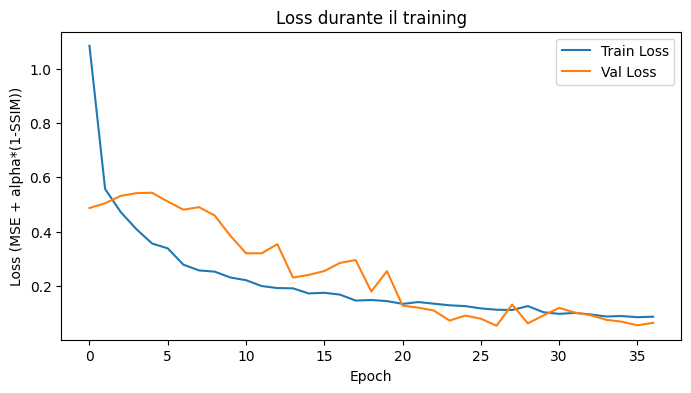

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


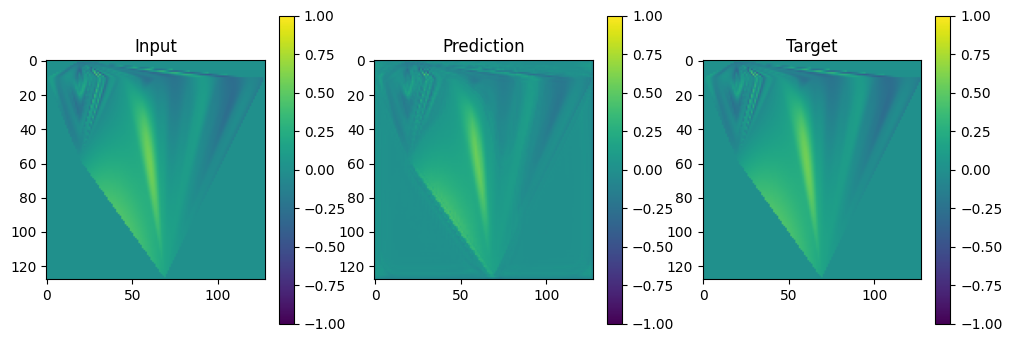

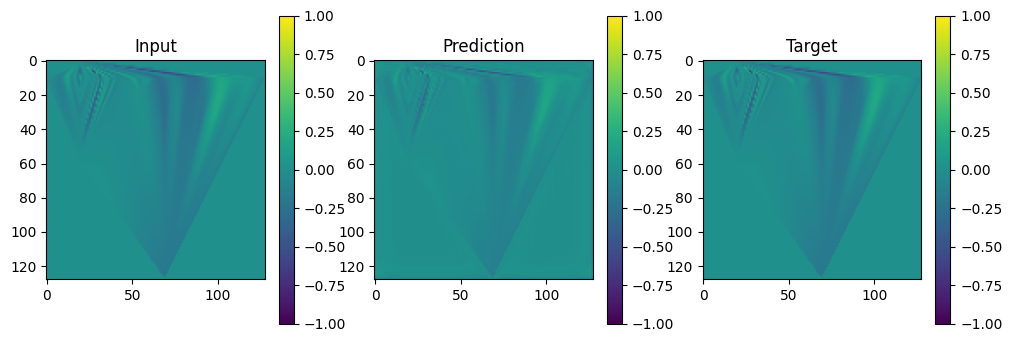

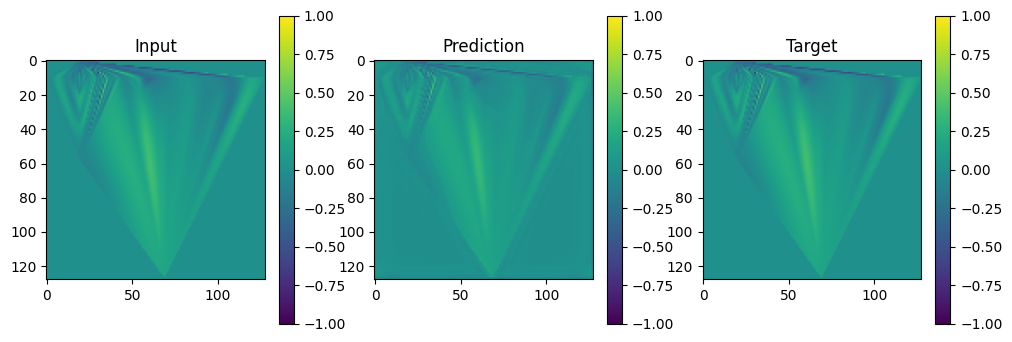

In [9]:
# 9.  Esecuzione del Pipeline

if __name__ == "__main__":
    # Parametri
    data_folder = r"C:\Users\Edoardo PC\Desktop\Aerodynamic flows\estratti"
    excel_path = r"C:\Users\Edoardo PC\Desktop\Aerodynamic flows\sensor locations.xlsx"
    original_freq = 204800
    target_freq = 50000
    duration_sec = 10    # secondi di dati da caricare
    step_time = 1000    # campioni fra un time-step e l'altro
    grid_size = (128,128) # dimensione della griglia di interpolazione

    # 1. Carica posizioni microfoni
    sensor_positions = load_sensor_locations(excel_path)
    if sensor_positions is None:
        print("Errore nel caricamento posizioni microfoni.")
        exit()

    # 2. Carica i dati .mat, limitando a 'duration_sec' secondi
    raw_data = load_mat_data(data_folder, max_channels=65, duration_sec=duration_sec, original_freq=original_freq)
    if raw_data is None:
        print("Errore nel caricamento dei dati raw.")
        exit()
    print("Shape raw_data (float16):", raw_data.shape)

    # 3. Downsampling
    raw_data = downsample_data(raw_data, original_freq=original_freq, target_freq=target_freq)
    print("Shape dopo downsampling:", raw_data.shape)

    # 4. Creazione dataset multi-time-step
    dataset_images = create_multistep_dataset(raw_data, sensor_positions, grid_size=grid_size, step=step_time)
    print("Dataset images shape:", dataset_images.shape)

    # 5. Training del modello con loss combinata
    model, history, (X_val, Y_val) = train_model(
        dataset_images,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        alpha=0.5
    )

    # 6. Visualizzazione curve di training
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE + alpha*(1-SSIM))")
    plt.legend()
    plt.title("Loss durante il training")
    plt.show()

    # 7. Predizione di test
    # Creiamo un batch dal validation set
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(4)
    val_batch = next(iter(val_dataset))
    X_val_batch, Y_val_batch = val_batch
    preds = model.predict(X_val_batch)

    # Plot di alcuni esempi
    num_show = min(3, X_val_batch.shape[0])
    for i in range(num_show):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(X_val_batch[i,...,0], cmap='viridis', vmin=-1, vmax=1)
        plt.title("Input")
        plt.colorbar()

        plt.subplot(1,3,2)
        plt.imshow(preds[i,...,0], cmap='viridis', vmin=-1, vmax=1)
        plt.title("Prediction")
        plt.colorbar()

        plt.subplot(1,3,3)
        plt.imshow(Y_val_batch[i,...,0], cmap='viridis', vmin=-1, vmax=1)
        plt.title("Target")
        plt.colorbar()
        plt.show()